# Forecasting a Time Series

## Library and Environment Setting

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import tensorflow as tf

# import warnings filter
from warnings import simplefilter
import warnings
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from pathlib import Path

IMAGES_PATH = Path() / "images" / "unsupervised_learning"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


## Load In the Data

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the Chicago's Data Portal.

In [4]:
from pathlib import Path

tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

We load the CSV file, set short column names, sort the rows by date, remove the redundant total column, and drop duplicate rows. 

The day_type column contains W for Weekdays, A for Saturdays, and U for Sundays or holidays.

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


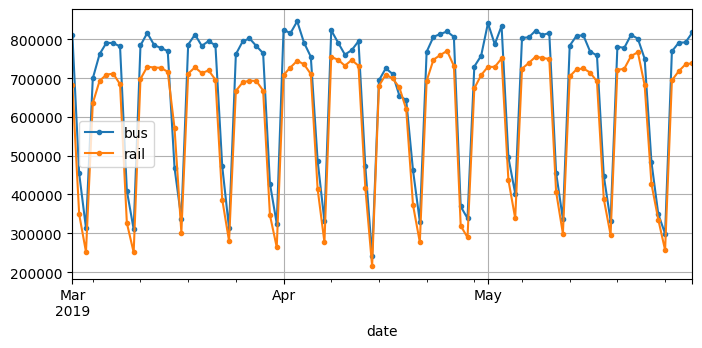

In [6]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

### Naive Method

we can see that a similar pattern is clearly repeated every week. This is called a weekly seasonality. In fact, it’s so strong in this case that forecasting tomorrow’s ridership by just copying the values from a week earlier will yield reasonably good results. This is called naive forecasting: simply copying a past value to make our forecast. Naive forecasting is often a great baseline, and it can even be tricky to beat in some cases.

In general, naive forecasting means copying the latest known value (e.g., forecasting that tomorrow will be the same as today). However, in our case, copying the value from the previous week works better, due to the strong weekly seasonality.

To visualize these naive forecasts, let’s overlay the two time series (for bus and rail) as well as the same time series lagged by one week (i.e., shifted toward the right) using dotted lines. We’ll also plot the difference between the two (i.e., the value at time t minus the value at time t – 7); this is called differencing 

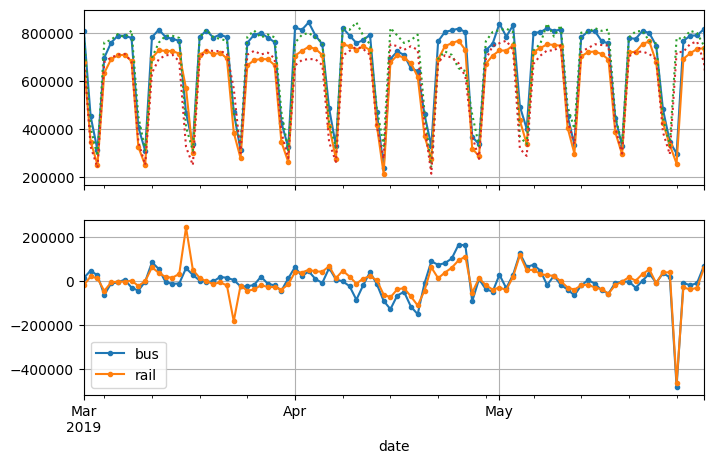

In [7]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"] #difference between the two (i.e., the value at time t minus the value at time t – 7)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

Not too bad! Notice how closely the lagged time series track the actual time series. When a time series is correlated with a lagged version of itself, we say that the time series is autocorrelated. As you can see, most of the differences are fairly small, except at the end of May. Maybe there was a holiday at that time? Let’s check the day_type column:

In [8]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Indeed, there was a long weekend back then: the Monday was the Memorial Day holiday. 

mean absolute error

In [9]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [10]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

It looks like our naive forecasts give us a MAPE of roughly 8.3% for bus and 9.0% for rail. It’s interesting to note that the MAE for the rail forecasts looks slightly better than the MAE for the bus forecasts, while the opposite is true for the MAPE. That’s because the bus ridership is larger than the rail ridership, so naturally the forecast errors are also larger, but when we put the errors into perspective, it turns out that the bus forecasts are actually slightly better than the rail forecasts.

Looking at the time series, there doesn’t appear to be any significant monthly seasonality, but let’s check whether there’s any yearly seasonality. We’ll look at the data from 2001 to 2019. To reduce the risk of data snooping, we’ll ignore more recent data for now. Let’s also plot a 12-month rolling average for each series to visualize long-term trends (see Figure 15-8):

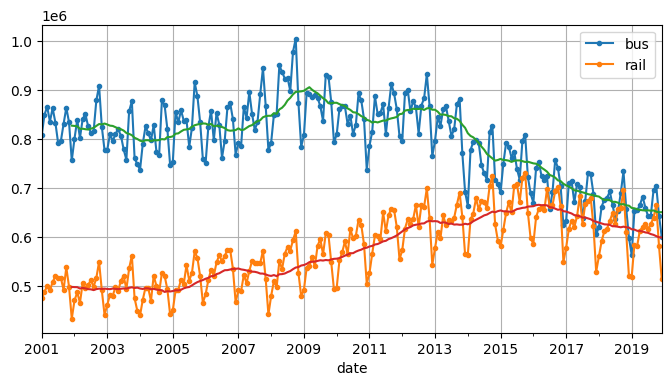

In [11]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

Yep! There’s definitely some yearly seasonality as well, although it is noisier than the weekly seasonality, and more visible for the rail series than the bus series: we see peaks and troughs at roughly the same dates each year. 

Let’s check what we get if we plot the 12-month difference using differencing

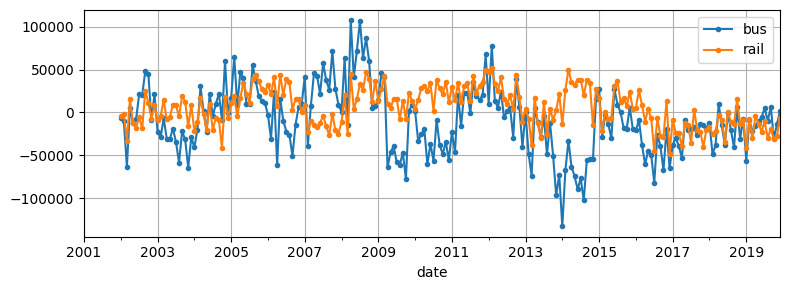

In [12]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

Notice how differencing not only removed the yearly seasonality, but it also removed the long-term trends. For example, the linear downward trend present in the time series from 2016 to 2019 became a roughly constant negative value in the differenced time series. In fact, differencing is a common technique used to remove trend and seasonality from a time series: it’s easier to study a stationary time series, meaning one whose statistical properties remain constant over time, without any seasonality or trends. Once you’re able to make accurate forecasts on the differenced time series, it’s easy to turn them into forecasts for the actual time series by just adding back the past values that were previously subtracted.

### SARIMA

Let’s see how to fit a SARIMA model to the rail time series, and use it to make a forecast for tomorrow’s ridership. We’ll pretend today is the last day of May 2019, and we want to forecast the rail ridership for “tomorrow”, the 1st of June, 2019. For this, we can use the statsmodels library, which contains many different statistical models, including the ARMA model and its variants, implemented by the ARIMA class:

In [13]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  

In [14]:
y_pred 

2019-06-01    427758.626368
Freq: D, dtype: float64

* We start by importing the ARIMA class, then we take the rail ridership data from the start of 2019 up to “today”, and we use asfreq("D") to set the time series’ frequency to daily: this doesn’t change the data at all in this case, since it’s already daily, but without this the ARIMA class would have to guess the frequency, and it would display a warning. 

* Next, we create an ARIMA instance, passing it all the data until “today”, and we set the model hyperparameters: order=(1, 0, 0) means that p = 1, d = 0, q = 0, and seasonal_order=(0, 1, 1, 7) means that P = 0, D = 1, Q = 1, and s = 7. Notice that the statsmodels API differs a bit from Scikit-Learn’s API, since we pass the data to the model at construction time, instead of passing it to the fit() method.

* Next, we fit the model, and we use it to make a forecast for “tomorrow”, the 1st of June, 2019.


In [15]:
df["rail"].loc["2019-06-01"]

379044

In [16]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

The forecast is 427,759 passengers, when in fact there were 379,044. Yikes, we’re 12.9% off—that’s pretty bad. It’s actually slightly worse than naive forecasting, which forecasts 426,932, off by 12.6%. But perhaps we were just unlucky that day? To check this, we can run the same code in a loop to make forecasts for every day in March, April, and May, and compute the MAE over that period:

In [17]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [18]:
mae

32040.720093360585

That’s much better! The MAE is about 32,041, which is significantly lower than the MAE we got with naive forecasting (42,143). So although the model is not perfect, it still beats naive forecasting by a large margin, on average.

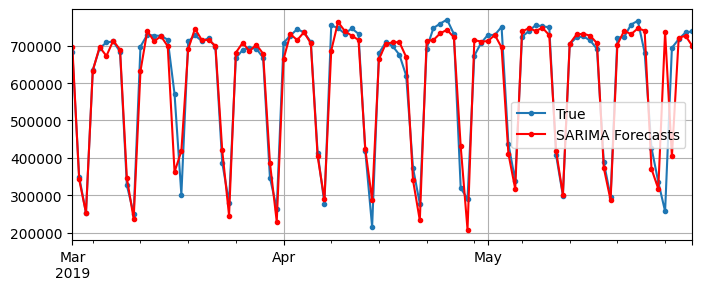

In [19]:
# displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

shows how to plot the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF)


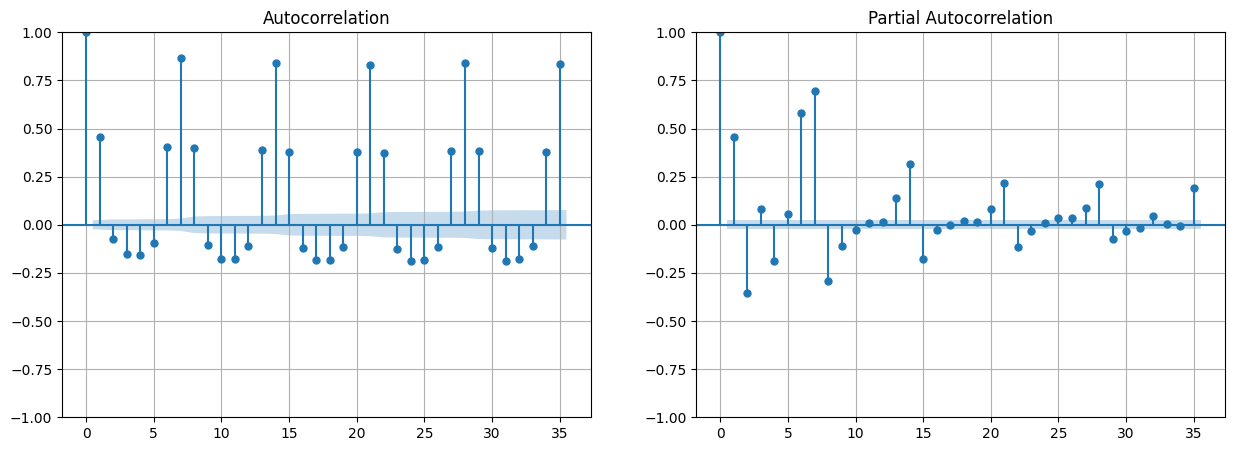

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

### Preparing the Data for Machine Learning Models

Keras actually has a nice utility function called tf.keras.utils.timeseries_ dataset_from_array() to help us prepare the training set. It takes a time series as input, and it builds a tf.data.Dataset containing all the windows of the desired length, as well as their corresponding targets. Here’s an example that takes a time series containing the numbers 0 to 5 and creates a dataset containing all the windows of length 3, with their corresponding targets, grouped into batches of size 2:

In [21]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], #3 steps into the future3, 4, and 5 in this case  
    sequence_length=3, #each sequence contain 3 steps
    batch_size=2 #2 batches as input at a time
)
list(my_dataset)


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

資料集中的每個樣本都是一個長度為 3 的視窗及其對應的目標（即緊接視窗之後的值）。 窗口為[0, 1, 2], [1, 2, 3], [2, 3, 4]，它們各自的目標為3, 4, 5。由於總共有3個窗口，即不是批量大小的倍數，最後一批僅包含一個窗口([[2,3,4]])而不是兩個。

Another way to get the same result is to use the window() method of tf.data’s Dataset class. It’s more complex, but it gives you full control, which will come in handy later in this chapter, so let’s see how it works. The window() method returns a dataset of window datasets:

In [22]:
for window_dataset in my_dataset.range(8).window(3, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 
1 2 3 
2 3 4 
3 4 5 
4 5 6 
5 6 7 
6 7 
7 


In [23]:
for window_dataset in my_dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [24]:
for window_dataset in my_dataset.range(6).window(4, shift=1, drop_remainder=True):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 


In this example, the dataset contains six windows, each shifted by one step compared to the previous one, and the last three windows are smaller because they’ve reached the end of the series. In general you’ll want to get rid of these smaller windows by passing drop_remainder=True to the window() method. The window() method returns a nested dataset, analogous to a list of lists. This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets.

Therefore, we must call the flat_map() method: it converts a nested dataset into a flat dataset (one that contains tensors, not datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}. Moreover, the flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening. For example, if you pass the function lambda ds: ds.batch(2) to flat_map(), then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset {[1, 2], [3, 4], [5, 6]}: it’s a dataset containing 3 tensors, each of size 2

In [25]:
dataset = my_dataset.range(6).window(4, shift=1, drop_remainder=True) #值不足4個的window就會被drop
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


Since each window dataset contains exactly four items, calling batch(4) on a window produces a single tensor of size 4. Great! We now have a dataset containing consecutive windows represented as tensors. Let’s create a little helper function to make it easier to extract windows from a dataset:

In [26]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [27]:
dataset = to_windows(my_dataset.range(6), 4) #range(6)代表數字由0-5，4代表每個winow最多4個值
list(dataset.batch(2)) #用batch = 2來看


[<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
 array([[0, 1, 2, 3],
        [1, 2, 3, 4]], dtype=int64)>,
 <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[2, 3, 4, 5]], dtype=int64)>]

* batch no.1 : [0, 1, 2, 3] 和 [1, 2, 3, 4]

* batch no.2 : [2, 3, 4, 5]，然後不夠長了

In [28]:
dataset = dataset.map(lambda window: (window[:-1], window[-1])) #分離unput跟target
list(dataset.batch(2))#用batch = 2來看

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

* batch no.1: 
    
    * input1 : [0, 1, 2], target: [3]
    
    * input2 : [1, 2, 3], target: [4]

* batch no.2:
    
    * input1 : [2, 3, 4], target: [5]
    
    * input2 : 不夠長了

As you can see, we now have the same output as we got earlier with the timeseries_dataset_from_array() function (with a bit more effort, but it will be worthwhile soon).

Now, before we start training, we need to split our data into a training period, a validation period, and a test period. We will focus on the rail ridership for now. We will also scale it down by a factor of one million, to ensure the values are near the 0–1 range; this plays nicely with the default weight initialization and learning rate:

In [29]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [30]:
rail_train 

date
2016-01-01    0.319835
2016-01-02    0.365509
2016-01-03    0.287661
2016-01-04    0.703185
2016-01-05    0.727716
                ...   
2018-12-27    0.453029
2018-12-28    0.493961
2018-12-29    0.307105
2018-12-30    0.265310
2018-12-31    0.386058
Name: rail, Length: 1096, dtype: float64

Next, let’s use timeseries_dataset_from_array() to create datasets for training and validation. Since gradient descent expects the instances in the training set to be independent and identically distributed (IID), , we must set the argument shuffle=True to shuffle the training windows (but not their contents):

In [31]:
seq_length = 56
tf.random.set_seed(42)  # ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [32]:
list(train_ds)

[(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
  array([[0.739158, 0.749136, 0.742502, ..., 0.777158, 0.509314, 0.421479],
         [0.725712, 0.762858, 0.749991, ..., 0.376485, 0.732335, 0.741141],
         [0.770186, 0.764653, 0.78316 , ..., 0.493961, 0.307105, 0.26531 ],
         ...,
         [0.510071, 0.719617, 0.813161, ..., 0.764611, 0.760471, 0.359088],
         [0.464903, 0.351102, 0.76766 , ..., 0.770507, 0.773696, 0.779012],
         [0.733693, 0.77807 , 0.76038 , ..., 0.381042, 0.675484, 0.697126]])>,
  <tf.Tensor: shape=(32,), dtype=float64, numpy=
  array([0.347259, 0.74504 , 0.386058, 0.460892, 0.660176, 0.797545,
         0.755604, 0.755558, 0.393884, 0.770507, 0.712596, 0.741773,
         0.723334, 0.323758, 0.481961, 0.805398, 0.762707, 0.779493,
         0.71522 , 0.272268, 0.692183, 0.730669, 0.320982, 0.796878,
         0.328391, 0.731858, 0.748709, 0.702745, 0.796057, 0.285153,
         0.429256, 0.719511])>),
 (<tf.Tensor: shape=(32, 56), dtype=float64, num

### Forecasting Using a Linear Model

Let’s try a basic linear model first. We will use the Huber loss, which usually works better than minimizing the MAE directly

In [33]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 0s 4ms/step - loss: 0.3143 - mae: 0.6476 - val_loss: 0.0359 - val_mae: 0.2330
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0245 - mae: 0.1783 - val_loss: 0.0084 - val_mae: 0.0979
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0089 - mae: 0.1012 - val_loss: 0.0066 - val_mae: 0.0869
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0075 - mae: 0.0918 - val_loss: 0.0057 - val_mae: 0.0791
Epoch 5/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0072 - mae: 0.0892 - val_loss: 0.0049 - val_mae: 0.0713
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0061 - mae: 0.0809 - val_loss: 0.0045 - val_mae: 0.0664
Epoch 7/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - mae: 0.0771 - val_loss: 0.0042 - val_mae: 0.0634
Epoch 8/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - m

In [34]:
# evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6 #Because we scale it down by a factor of one million before, to ensure the values are near the 0–1 range

3/3 [==============================] - 0s 997us/step - loss: 0.0023 - mae: 0.0373


37274.03283119202

Better than naive forecasting, but worse than the SARIMA model.

### Forecasting Using a Simple RNN

we will create a model with a larger recurrent layer, containing 32 recurrent neurons, and we will add a dense output layer on top of it with a single output neuron and no activation function.

In [35]:
#defines a utility function we'll reuse several time
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [36]:
tf.random.set_seed(42) 
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [37]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500


33/33 [==============================] - 1s 11ms/step - loss: 0.0492 - mae: 0.2172 - val_loss: 0.0153 - val_mae: 0.1216
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0150 - mae: 0.1409 - val_loss: 0.0116 - val_mae: 0.1130
Epoch 3/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0118 - mae: 0.1251 - val_loss: 0.0057 - val_mae: 0.0859
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0054 - mae: 0.0779 - val_loss: 0.0040 - val_mae: 0.0675
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0044 - mae: 0.0652 - val_loss: 0.0045 - val_mae: 0.0725
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0041 - mae: 0.0624 - val_loss: 0.0028 - val_mae: 0.0474
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0037 - mae: 0.0566 - val_loss: 0.0025 - val_mae: 0.0472
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0044 - mae: 0.0656 

29200.69359242916

### Forecasting Using a Deep RNN

In [38]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [39]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500


33/33 [==============================] - 2s 23ms/step - loss: 0.0197 - mae: 0.1231 - val_loss: 0.0047 - val_mae: 0.0739
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0045 - mae: 0.0666 - val_loss: 0.0042 - val_mae: 0.0691
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0042 - mae: 0.0623 - val_loss: 0.0023 - val_mae: 0.0444
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0040 - mae: 0.0606 - val_loss: 0.0022 - val_mae: 0.0423
Epoch 5/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0036 - mae: 0.0550 - val_loss: 0.0021 - val_mae: 0.0379
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0039 - mae: 0.0573 - val_loss: 0.0023 - val_mae: 0.0423
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0040 - mae: 0.0596 - val_loss: 0.0024 - val_mae: 0.0430
Epoch 8/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0039 - mae: 

29856.3651740551

Make sure to set return_sequences=True for all recurrent layers (except the last one, if you only care about the last output). If you forget to set this parameter for one recurrent layer, it will output a 2D array containing only the output of the last time step, instead of a 3D array containing outputs for all time steps. The next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

### Forecasting Multivariate Time Series


A great quality of neural networks is their flexibility: in particular, they can deal with multivariate time series with almost no change to their architecture. For example, let’s try to forecast the rail time series using both the bus and rail data as input. In fact, let’s also throw in the day type! Since we can always know in advance whether tomorrow is going to be a weekday, a weekend, or a holiday, we can shift the day type series one day into the future, so that the model is given tomorrow’s day type as input.


In [40]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [41]:
df.head(8)

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
2001-01-06,A,577401,255356
2001-01-07,U,375831,169825
2001-01-08,W,985221,590706


In [42]:
df_mulvar.head(8)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0
2001-01-06,0.577401,0.255356,0,1,0
2001-01-07,0.375831,0.169825,0,0,1
2001-01-08,0.985221,0.590706,0,0,1


In [43]:
df_mulvar.tail(5)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2021-11-26,0.257700,0.189694,1,0,0
2021-11-27,0.237839,0.187065,0,1,0
2021-11-28,0.184817,0.147830,0,0,1
2021-11-29,0.421322,0.276090,0,0,1
2021-11-30,0.450230,0.302349,0,0,0


In [44]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [45]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [46]:
tf.random.set_seed(42) 
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500


33/33 [==============================] - 1s 9ms/step - loss: 0.0506 - mae: 0.2029 - val_loss: 0.0048 - val_mae: 0.0852
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0025 - mae: 0.0520 - val_loss: 0.0037 - val_mae: 0.0790
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0021 - mae: 0.0468 - val_loss: 0.0011 - val_mae: 0.0373
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0018 - mae: 0.0427 - val_loss: 0.0024 - val_mae: 0.0624
Epoch 5/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0015 - mae: 0.0389 - val_loss: 8.1809e-04 - val_mae: 0.0301
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0380 - val_loss: 0.0018 - val_mae: 0.0513
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0400 - val_loss: 9.7292e-04 - val_mae: 0.0345
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0014 - mae: 

22815.890610218048

Notice that the only difference from the univar_model RNN we built earlier is the input shape: at each time step, the model now receives five inputs instead of one. This model actually reaches a validation MAE of 22,062, which improves a lot. 

### Forecasting Several Steps Ahead

In [47]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 14ms/step


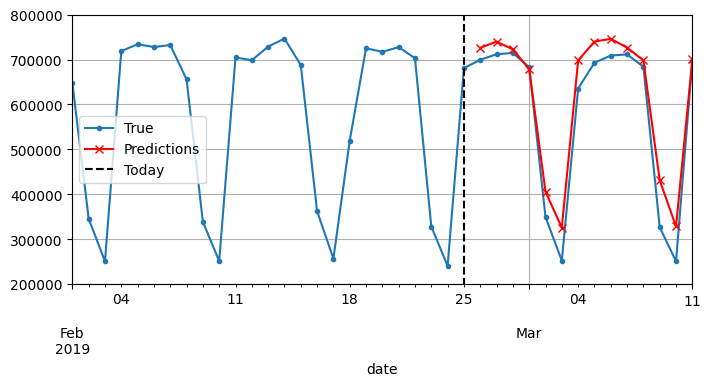

In [48]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")

plt.show()

* 方法二

In [49]:
tf.random.set_seed(42) 

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [50]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 10ms/step - loss: 0.0677 - mae: 0.2816 - val_loss: 0.0220 - val_mae: 0.1658
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0164 - mae: 0.1415 - val_loss: 0.0113 - val_mae: 0.1131
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0112 - mae: 0.1149 - val_loss: 0.0083 - val_mae: 0.0985
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0092 - mae: 0.1018 - val_loss: 0.0065 - val_mae: 0.0879
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0079 - mae: 0.0938 - val_loss: 0.0057 - val_mae: 0.0806
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0072 - mae: 0.0876 - val_loss: 0.0048 - val_mae: 0.0755
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0066 - mae: 0.0834 - val_loss: 0.0043 - val_mae: 0.0710
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0062 - 

34041.43452644348

In [51]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 67ms/step


In [52]:
Y_pred

array([[0.68869334, 0.7108675 , 0.6968128 , 0.71838623, 0.37733012,
        0.27596357, 0.6344935 , 0.7164431 , 0.7024031 , 0.7276864 ,
        0.67282355, 0.39238405, 0.28205004, 0.6664139 ]], dtype=float32)

### Sequence to Sequence

In [53]:
my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:], #3 steps into the future3, 4, and 5 in this case  
    sequence_length=3, #each sequence contain 3 steps
    batch_size=2 #2 batches as input at a time
)
list(my_dataset)


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [54]:
for window_dataset in my_dataset.range(7).window(3, shift=1, drop_remainder=True):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 
1 2 3 
2 3 4 
3 4 5 
4 5 6 


In [55]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [56]:
my_series = my_dataset.range(7)
dataset = to_windows(my_series, 3)
list(dataset)

[<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 2], dtype=int64)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3], dtype=int64)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([2, 3, 4], dtype=int64)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 4, 5], dtype=int64)>,
 <tf.Tensor: shape=(3,), dtype=int64, numpy=array([4, 5, 6], dtype=int64)>]

In [57]:

my_series = my_dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

Now we can use the map() method to split these windows of windows into inputs and targets:

In [58]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

S[:, 0]代表從第一個sequence(0)的每一個step(:)，也就是[0, 1, 2, 3]開始， 而S[:, 1:]代表每一個sequence(:)中每一個step的接下來的值，也就是target(0是當下，因此1:就是接下來的值)

Now the dataset contains sequences of length 4 as inputs, and the targets are sequences containing the next two steps, for each time step. For example, the first input sequence is [0, 1, 2, 3], and its corresponding targets are [[1, 2], [2, 3], [3, 4], [4, 5]], which are the next two values for each time step。 

* 第一個input sequence是[0, 1, 2, 3]，在這個sequence中:

    * step 0 的時候預測下兩步，target便是[1, 2]
    * step 1 的時候預測下兩步，target便是[2, 3]
    * step 2 的時候預測下兩步，target便是[3, 4]
    * step 3 的時候預測下兩步，target便是[4, 5]

* 第二個input sequence是[0, 1, 2, 3]，在這個sequence中:

    * step 1 的時候預測下兩步，target便是[2, 3]
    * step 2 的時候預測下兩步，target便是[3, 4]
    * step 3 的時候預測下兩步，target便是[4, 5]
    * step 4 的時候預測下兩步，target便是[5, 6]

In [59]:
mulvar_train.head(20)

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2016-01-01,0.303321,0.319835,1,0,0
2016-01-02,0.448859,0.365509,0,1,0
2016-01-03,0.340540,0.287661,0,0,1
2016-01-04,0.829429,0.703185,0,0,1
2016-01-05,0.846789,0.727716,0,0,1
2016-01-06,0.853904,0.733167,0,0,1
2016-01-07,0.846274,0.736809,0,0,1
2016-01-08,0.841494,0.732495,1,0,0
2016-01-09,0.469539,0.391597,0,1,0


In [60]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

一次32個sequence一起輸入，一個sequence(window)包含56個step，然後每個window預測14個未來的step

S[:, 0]代表從第一個sequence(0)的每一個step(:)，也就是[value1, value2...., value56]開始， 而S[:, 1:, 1]代表每一個sequence(:)中每一個step的接下來的值(一共14個接下來的值)，也就是target(0是當下，因此1:就是接下來的值)，位後一個1代表指預測一個column(rail)

In [61]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

And lastly, we can build the sequence-to-sequence model:

In [62]:
tf.random.set_seed(42)  
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500


33/33 [==============================] - 1s 18ms/step - loss: 0.0587 - mae: 0.2475 - val_loss: 0.0168 - val_mae: 0.1427
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0116 - mae: 0.1188 - val_loss: 0.0096 - val_mae: 0.1015
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0079 - mae: 0.0941 - val_loss: 0.0075 - val_mae: 0.0867
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0064 - mae: 0.0819 - val_loss: 0.0063 - val_mae: 0.0769
Epoch 5/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0058 - mae: 0.0749 - val_loss: 0.0053 - val_mae: 0.0683
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0054 - mae: 0.0717 - val_loss: 0.0053 - val_mae: 0.0682
Epoch 7/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0051 - mae: 0.0685 - val_loss: 0.0049 - val_mae: 0.0637
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0049 - mae: 0.0660 

46213.58588337898

In [63]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 129ms/step


In [64]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 10ms/step
MAE for +1: 23,534
MAE for +2: 28,081
MAE for +3: 30,400
MAE for +4: 32,676
MAE for +5: 33,146
MAE for +6: 34,004
MAE for +7: 33,966
MAE for +8: 33,701
MAE for +9: 33,654
MAE for +10: 34,911
MAE for +11: 36,510
MAE for +12: 35,462
MAE for +13: 36,100
MAE for +14: 33,634


### Deep RNNs with Layer Norm

In [65]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

* Our LNSimpleRNNCell class inherits from the tf.keras.layers.Layer class, just like any custom layer. 

* The constructor takes the number of units and the desired activation function and sets the state_size and output_size attributes, then creates a SimpleRNN Cell with no activation function (because we want to perform layer normalization after the linear operation but before the activation function). Then the constructor creates the LayerNormalization layer, and finally it fetches the desired activation function. 

* The call() method starts by applying the simpleRNNCell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a SimpleRNNCell, the outputs are just equal to the hidden states: in other words, new_states[0] is equal to outputs, so we can safely ignore new_states in the rest of the call() method). Next, the call() method applies layer normalization, followed by the activation function. Finally, it returns the outputs twice: once as the outputs, and once as the new hidden states.


In [66]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [67]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=30)

Epoch 1/30


33/33 [==============================] - 1s 17ms/step - loss: 0.0773 - mae: 0.2750 - val_loss: 0.0167 - val_mae: 0.1482
Epoch 2/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0150 - mae: 0.1443 - val_loss: 0.0159 - val_mae: 0.1270
Epoch 3/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0126 - mae: 0.1318 - val_loss: 0.0139 - val_mae: 0.1196
Epoch 4/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0115 - mae: 0.1240 - val_loss: 0.0126 - val_mae: 0.1136
Epoch 5/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0107 - mae: 0.1168 - val_loss: 0.0120 - val_mae: 0.1088
Epoch 6/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0100 - mae: 0.1102 - val_loss: 0.0112 - val_mae: 0.1045
Epoch 7/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0094 - mae: 0.1049 - val_loss: 0.0116 - val_mae: 0.1053
Epoch 8/30
33/33 [==============================] - 0s 11ms/step - loss: 0.0089 - mae: 0.1001 

64304.716885089874

## LSTM

In [68]:
tf.random.set_seed(42) 
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [69]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


33/33 [==============================] - 2s 20ms/step - loss: 0.0601 - mae: 0.2638 - val_loss: 0.0199 - val_mae: 0.1630
Epoch 2/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0177 - mae: 0.1607 - val_loss: 0.0182 - val_mae: 0.1462
Epoch 3/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0161 - mae: 0.1527 - val_loss: 0.0172 - val_mae: 0.1432
Epoch 4/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0153 - mae: 0.1487 - val_loss: 0.0165 - val_mae: 0.1391
Epoch 5/5
3/3 [==============================] - 0s 9ms/step - loss: 0.0158 - mae: 0.1358


135791.48054122925

## GRUs

In [70]:
tf.random.set_seed(42)  
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [71]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 19ms/step - loss: 0.0628 - mae: 0.2682 - val_loss: 0.0185 - val_mae: 0.1574
Epoch 2/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0156 - mae: 0.1468 - val_loss: 0.0155 - val_mae: 0.1368
Epoch 3/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0132 - mae: 0.1358 - val_loss: 0.0141 - val_mae: 0.1287
Epoch 4/5
33/33 [==============================] - 0s 10ms/step - loss: 0.0120 - mae: 0.1281 - val_loss: 0.0129 - val_mae: 0.1225
Epoch 5/5
3/3 [==============================] - 0s 9ms/step - loss: 0.0120 - mae: 0.1175


117522.05342054367

## Using One-Dimensional Convolutional Layers to Process Sequences

In [72]:
tf.random.set_seed(42)  
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [73]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 18ms/step - loss: 0.0538 - mae: 0.2542 - val_loss: 0.0206 - val_mae: 0.1536
Epoch 2/5
31/31 [==============================] - 0s 9ms/step - loss: 0.0159 - mae: 0.1500 - val_loss: 0.0162 - val_mae: 0.1374
Epoch 3/5
31/31 [==============================] - 0s 9ms/step - loss: 0.0132 - mae: 0.1367 - val_loss: 0.0142 - val_mae: 0.1266
Epoch 4/5
31/31 [==============================] - 0s 9ms/step - loss: 0.0115 - mae: 0.1251 - val_loss: 0.0124 - val_mae: 0.1167
Epoch 5/5
1/1 [==============================] - 0s 44ms/step - loss: 0.0107 - mae: 0.1083


108323.37290048599

### WaveNet

In [74]:
tf.random.set_seed(42)  
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [75]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 1s 19ms/step - loss: 0.0838 - mae: 0.3280 - val_loss: 0.0249 - val_mae: 0.1553
Epoch 2/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0171 - mae: 0.1560 - val_loss: 0.0188 - val_mae: 0.1535
Epoch 3/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0160 - mae: 0.1573 - val_loss: 0.0186 - val_mae: 0.1527
Epoch 4/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0158 - mae: 0.1560 - val_loss: 0.0183 - val_mae: 0.1516
Epoch 5/5
1/1 [==============================] - 0s 49ms/step - loss: 0.0180 - mae: 0.1497


149701.2823820114

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [76]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate
    
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [77]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [78]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 2s 20ms/step - loss: 0.0804 - mae: 0.3141 - val_loss: 0.0209 - val_mae: 0.1635
Epoch 2/5
31/31 [==============================] - 0s 11ms/step - loss: 0.0144 - mae: 0.1398 - val_loss: 0.0149 - val_mae: 0.1284
Epoch 3/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0113 - mae: 0.1233 - val_loss: 0.0130 - val_mae: 0.1176
Epoch 4/5
31/31 [==============================] - 0s 10ms/step - loss: 0.0098 - mae: 0.1121 - val_loss: 0.0115 - val_mae: 0.1103
Epoch 5/5
1/1 [==============================] - 0s 31ms/step - loss: 0.0103 - mae: 0.1050


104959.53261852264

--------------------

Download the Bach chorales dataset and unzip it. It is composed of 382 chorales 10. composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played). Train a model—recurrent, convolutional, or both—that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out Google’s Coconet model, which was used for a nice Google doodle about Bach.